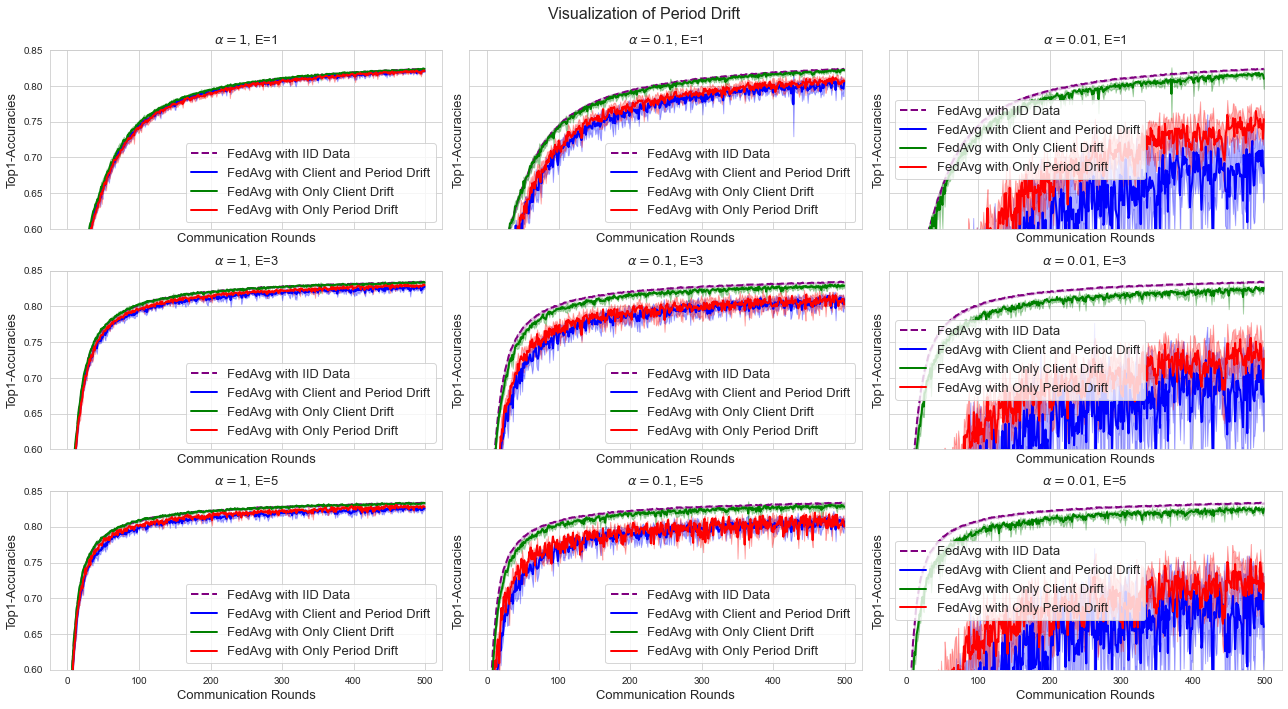

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 读取CSV文件
df = pd.read_csv('nips_2023_rebuttal_period_client_drift_femnist.csv')

# 2. 提取需要的列：'seed', 'iid', 'local_epochs', 'method', 'recorder'
df = df[['seed', 'iid', 'local_epochs', 'method', 'recorder']]

# 将 'nan' 字符串替换为 numpy 的 nan，以便正确地评估
df['recorder'] = df['recorder'].str.replace('nan', 'np.nan')

# 3. 舍弃包含NaN值的记录：检查'recorder'列中的'loss'是否包含NaN，并舍弃这些行
df = df[df['recorder'].apply(lambda x: 'loss' in eval(x) and not any(pd.isna(eval(x)['loss'])))]

# 4. 初始化绘图设置
iid_settings = ['alpha_1', 'alpha_0.1', 'alpha_0.01']
local_epochs_settings = [1, 3, 5]
methods = ['fedavg', 'fedavg_client_drift_only', 'fedavg_period_drift_only']
methods_names = {'fedavg':'FedAvg with Client and Period Drift', 'fedavg_client_drift_only':'FedAvg with Only Client Drift', 'fedavg_period_drift_only':'FedAvg with Only Period Drift'}

# 设置Seaborn风格
sns.set_style("whitegrid")
sns.set_palette("deep")

# 为每种组合创建子图，调换行和列
fig, axes = plt.subplots(len(local_epochs_settings), len(iid_settings), figsize=(18, 10), sharex=True, sharey=True)

# 定义一个新颜色用于iid的情况
color_map = {
    'fedavg': 'blue',
    'fedavg_client_drift_only': 'green',
    'fedavg_period_drift_only': 'red',
    'iid': 'purple'
}
alpha={'natural':r"natural",'alpha_1':r"$\alpha=1$",'alpha_0.1':r"$\alpha=0.1$",'alpha_0.01':r"$\alpha=0.01$"}

# 设置 matplotlib 支持 LaTeX
# plt.rc('text', usetex=True)

# 5. 对于每种local_epochs、iid和method的组合，计算平均值和标准差，并绘制曲线及其置信区间

font_legend = 13
font_title = 16
for j, iid_setting in enumerate(iid_settings):
    for i, local_epoch in enumerate(local_epochs_settings):
        ax = axes[i, j]
        
        # 先绘制iid的情况
        subset_iid = df[(df['iid'] == 'iid') & (df['local_epochs'] == local_epoch)]
        if not subset_iid.empty:
            acc_values_iid = subset_iid['recorder'].apply(lambda x: eval(x)['acc']).tolist()
            mean_acc_iid = np.mean(acc_values_iid, axis=0)[:500]  # 只取前500个数据点
            std_acc_iid = np.std(acc_values_iid, axis=0)[:500]
            epochs_iid = range(len(mean_acc_iid))
            
            ax.set_ylim((0.6, 0.85))
            ax.plot(epochs_iid, mean_acc_iid, label='FedAvg with IID Data', color=color_map['iid'], linewidth=2, linestyle='--')
            ax.fill_between(epochs_iid, mean_acc_iid-std_acc_iid, mean_acc_iid+std_acc_iid, color=color_map['iid'], alpha=0.2)

        # 接着绘制其他三种方法的曲线
        for method in methods:
            subset = df[(df['iid'] == iid_setting) & (df['local_epochs'] == local_epoch) & (df['method'] == method)]
            if not subset.empty:
                acc_values = subset['recorder'].apply(lambda x: eval(x)['acc']).tolist()
                mean_acc = np.mean(acc_values, axis=0)[:500]  # 只取前500个数据点
                std_acc = np.std(acc_values, axis=0)[:500]
                epochs = range(len(mean_acc))
                
                ax.plot(epochs, mean_acc, label=methods_names[method], color=color_map[method], linewidth=2)
                ax.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, color=color_map[method], alpha=0.3)

        # 设置子图的标题、横纵坐标标签、图例
        ax.set_title(alpha[iid_setting]+ r", E={}".format(local_epoch), fontsize=font_legend)
        ax.set_xlabel("Communication Rounds", fontsize=font_legend)
        ax.set_ylabel("Top1-Accuracies", fontsize=font_legend)
        ax.legend(frameon=True, fontsize=font_legend)

# 调整图形的布局和标题
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Visualization of Period Drift", fontsize=font_title)
plt.show()
fig.savefig('visualization_of_period_drift.pdf', bbox_inches='tight')

/tmp/ipykernel_20020/2373715304.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


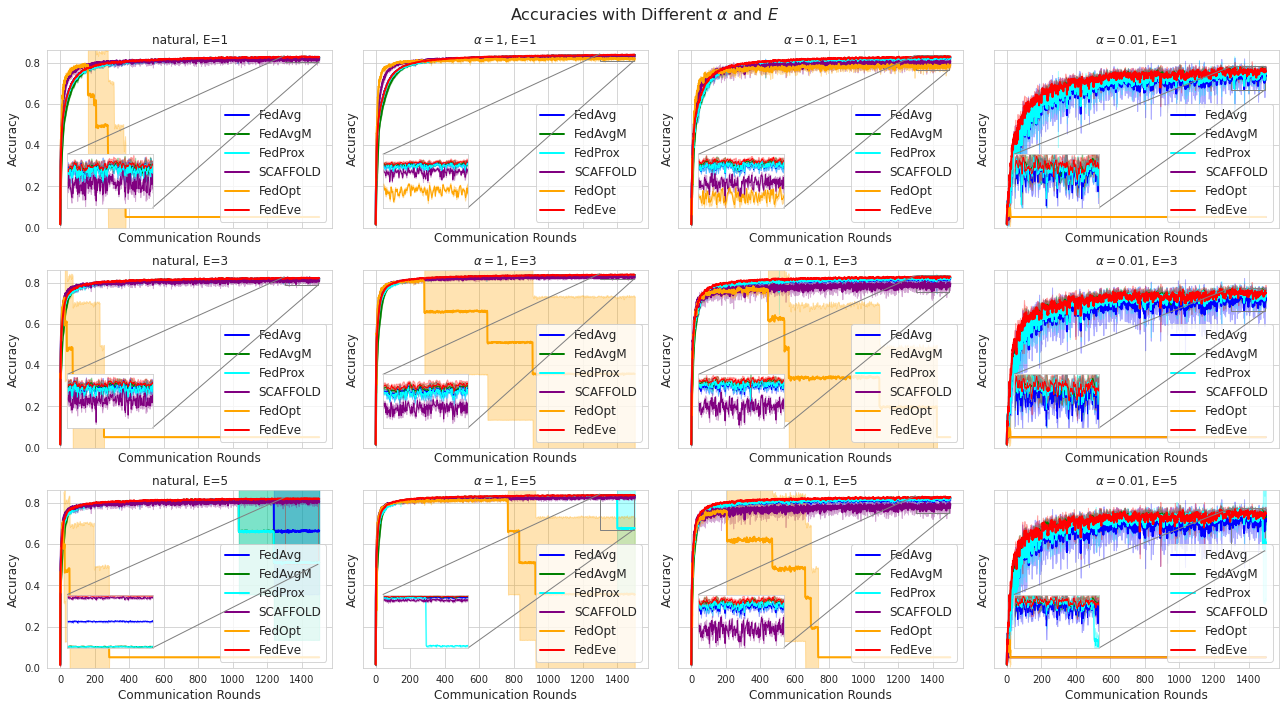

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Load the original data
df = pd.read_csv('nips_2023_rebuttal_different_local_epochs_femnist.csv')
df['recorder'] = df['recorder'].str.replace('nan', 'np.nan')
df['recorder'] = df['recorder'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None)
df['acc_list'] = df['recorder'].apply(lambda x: x['acc'] if x and 'acc' in x else None)
df_relevant = df[['seed', 'method', 'iid', 'local_epochs', 'acc_list']]

# Load the fedeve data
df_fedeve = pd.read_csv('nips_2023_rebuttal_fedeve_femnist.csv')
df_fedeve['recorder'] = df_fedeve['recorder'].str.replace('nan', 'np.nan')
df_fedeve = df_fedeve[df_fedeve['recorder'].apply(lambda x: 'loss' in eval(x) and not any(pd.isna(eval(x)['loss'])))]
df_fedeve['recorder'] = df_fedeve['recorder'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("{") else None)
df_fedeve['acc_list'] = df_fedeve['recorder'].apply(lambda x: x['acc'] if x and 'acc' in x else None)
df_fedeve_relevant = df_fedeve[['seed', 'method', 'iid', 'local_epochs', 'acc_list']]

# Combine the data
df_combined = pd.concat([df_relevant, df_fedeve_relevant])

# Redefining necessary settings
alpha={'natural':r"natural",'alpha_1':r"$\alpha=1$",'alpha_0.1':r"$\alpha=0.1$",'alpha_0.01':r"$\alpha=0.01$"}

# Define methods and color map
methods = ["fedavg", "fedavgm", "fedprox", "scaffold", "fedopt", "fedeve"]
methods_names = {"fedavg":'FedAvg', "fedavgm":'FedAvgM', "fedprox":'FedProx', "scaffold":'SCAFFOLD', "fedopt":'FedOpt', "fedeve":'FedEve'}
color_map = {
    'fedavg': 'blue',
    'fedavgm': 'green',
    'fedprox': 'cyan',
    'scaffold': 'purple',
    'fedopt': 'orange',
    'fedeve': 'red'
}

# Plotting settings
iid_settings = ["natural", "alpha_1", "alpha_0.1", "alpha_0.01"]
local_epochs_settings = [1, 3, 5]
sns.set_style("whitegrid")
sns.set_palette("deep")

# Plot the data with correctly zoomed-in area again
fig, axes = plt.subplots(len(local_epochs_settings), len(iid_settings), figsize=(18, 10), sharex=True, sharey=True)

for j, iid_setting in enumerate(iid_settings):
    for i, local_epoch in enumerate(local_epochs_settings):
        ax = axes[i, j]
        
        max_acc = 0  # variable to store maximum accuracy across all methods for current subplot
        min_acc = 1  # variable to store minimum accuracy across all methods for current subplot
        
        for method in methods:
            subset = df_combined[(df_combined['iid'] == iid_setting) & 
                                 (df_combined['local_epochs'] == local_epoch) & 
                                 (df_combined['method'] == method)]
            if not subset.empty:
                acc_values = list(subset['acc_list'])
                mean_acc = np.mean(acc_values, axis=0)
                if mean_acc[1300] > 0.4:
                    max_acc = max(max_acc, max(mean_acc[1300:1495]))
                    min_acc = min(min_acc, min(mean_acc[1300:1495]))
#                     print(method)
#                     print('max ', max_acc)
#                     print('min', min_acc)
                std_acc = np.std(acc_values, axis=0)
                epochs = range(len(mean_acc))
                ax.plot(epochs, mean_acc, label=methods_names[method], color=color_map[method], linewidth=2)
                ax.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, color=color_map[method], alpha=0.3)
        
        # Set up the zoom effect for each subplot
        axins = inset_axes(ax, width="30%", height="30%", loc="lower left", borderpad=2)
        
        for method in methods:

            subset = df_combined[(df_combined['iid'] == iid_setting) & 
                                 (df_combined['local_epochs'] == local_epoch) & 
                                 (df_combined['method'] == method)]
            if not subset.empty:
                acc_values = list(subset['acc_list'])
                mean_acc = np.mean(acc_values, axis=0)
                epochs = range(len(mean_acc))
                if mean_acc[1000] > 0.4:
                    axins.plot(epochs, mean_acc, label=methods_names[method], color=color_map[method], linewidth=1)
                    axins.fill_between(epochs, mean_acc-std_acc, mean_acc+std_acc, color=color_map[method], alpha=0.3)
        
        # Define the zoom-in area focusing on the top accuracies
        x1, x2, y1, y2 = 1300, 1495, min_acc, max_acc  # specify the limits for zoom
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1*0.995, y2*1.005)
#         axins.set_ylim(y1, y2)
        
        # Remove the ticks in the zoom-in area
        axins.set_xticks([])
        axins.set_yticks([])
        
        # Draw the connection lines between the original plot and the zoom-in area
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)
        
        ax.set_title(alpha[iid_setting]+ r", E={}".format(local_epoch))
        ax.set_xlabel("Communication Rounds", fontsize=12)
        ax.set_ylabel("Accuracy", fontsize=12)
#         ax.legend(frameon=True, loc="upper left", fontsize=12)
        ax.set_ylim((0, 0.86))
        ax.legend(frameon=True, loc="lower right", fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(r"Accuracies with Different $\alpha$ and $E$", fontsize=16)
plt.show()
fig.savefig('training_accuracy_across_settings_with_correct_zoom_and_fedeve.pdf', bbox_inches='tight')

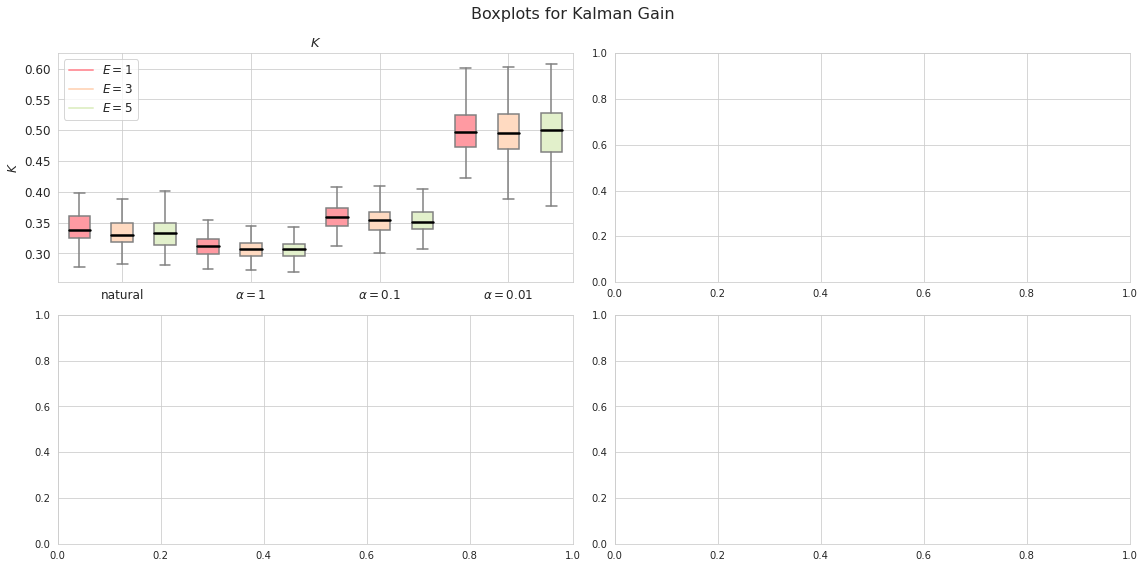

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('nips_2023_rebuttal_fedeve_femnist.csv')

# Define settings and columns of interest
iid_settings_updated = ['natural', 'alpha_1', 'alpha_0.1', 'alpha_0.01']
local_epochs_settings = [1, 3, 5]
columns = ['kal_R', 'kal_Q', 'kal_sigma', 'kal_K']
columns_names = {'kal_R':r'$\sigma^2_R$', 'kal_Q':r'$\sigma^2_Q$', 'kal_sigma':r'$\sigma^2_{state}$', 'kal_K':r'$K$'}

# Function to extract Kalman parameters
def extract_kalman_from_recorder(param, data_frame):
    all_values = []
    for entry in data_frame['recorder']:
        try:
            parsed_entry = eval(entry)
            all_values.append(parsed_entry[param])
        except:
            all_values.append([])
    return all_values

# Function to compute mean and std
def compute_mean_std(all_values, axis):
    max_length = max(map(len, all_values))
    padded_values = [values + [np.nan] * (max_length - len(values)) for values in all_values]
    array_values = np.array(padded_values)
    mean_values = np.nanmean(array_values, axis=axis)
    std_values = np.nanstd(array_values, axis=axis)
    return mean_values, std_values

# Function to generate stats data
def generate_stats_data(axis):
    stats_data = {}
    for iid in iid_settings_updated:
        for epochs in local_epochs_settings:
            key = f"{iid}_epochs{epochs}"
            stats_data[key] = {}
            filtered_data = df[(df['iid'] == iid) & (df['local_epochs'] == epochs)]
            for col in columns:
                all_values = extract_kalman_from_recorder(col, filtered_data)
                mean_values, std_values = compute_mean_std(all_values, axis)
                stats_data[key][col] = {
                    'mean_values': mean_values,
                    'std_values': std_values,
                    'overall_mean': np.mean(mean_values),
                    'overall_std': np.mean(std_values),
                }
    return stats_data

# Function to plot the stats data
def plot_kalman_parameter_for_axis(parameter, stats_data, title_suffix):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    fig.suptitle(f"{parameter} values for different settings {title_suffix}", fontsize=20)
    for idx, iid in enumerate(iid_settings_updated):
        for jdx, epochs in enumerate(local_epochs_settings):
            ax = axes[jdx, idx]
            key = f"{iid}_epochs{epochs}"
            mean_values = stats_data[key][parameter]['mean_values']
            std_values = stats_data[key][parameter]['std_values']
            rounds = list(range(len(mean_values)))
            ax.plot(rounds, mean_values, label='Mean')
            ax.fill_between(rounds, mean_values - std_values, mean_values + std_values, alpha=0.2)
            ax.set_title(f"iid: {iid}, Local Epochs: {epochs}")
            ax.set_xlabel("Communication Rounds")
            ax.set_ylabel(parameter)
            ax.legend()
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Generate stats data and plot for both axis=0 and axis=1
stats_data_axis0 = generate_stats_data(0)
stats_data_axis1 = generate_stats_data(1)



improved_epoch_colors = {
    1: '#FF9AA2',
    3: '#FFDAC1',
    5: '#E2F0CB'
}
iid_settings_updated = ['natural', 'alpha_1', 'alpha_0.1', 'alpha_0.01']
alpha={'natural':r"natural",'alpha_1':r"$\alpha=1$",'alpha_0.1':r"$\alpha=0.1$",'alpha_0.01':r"$\alpha=0.01$"}
xlabels=[r"natural",r"$\alpha=1$",r"$\alpha=0.1$",r"$\alpha=0.01$"]
kalman_params=['kal_R', 'kal_Q', 'kal_sigma', 'kal_K']
def plot_enhanced_boxplots(stats_data, last_n=100):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    boxprops = dict(linewidth=1.5, color='gray')
    medianprops = dict(linewidth=2.5, color='black')
    whiskerprops = dict(linewidth=1.5, color='gray')
    capprops = dict(linewidth=1.5, color='gray')
    
    for ax, param in zip(axes.ravel(), kalman_params):
        all_data = []
        for iid in iid_settings_updated:
            for epochs in local_epochs_settings:
                setting_data = stats_data[f"{iid}_epochs{epochs}"][param]['mean_values'][-last_n:]
                all_data.append(setting_data)
        box_positions = range(1, len(iid_settings_updated) * len(local_epochs_settings) + 1)
        bp = ax.boxplot(all_data, positions=box_positions, patch_artist=True, showfliers=False, 
                        boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
        for patch, (_, epochs) in zip(bp['boxes'], [(iid, epochs) for iid in iid_settings_updated for epochs in local_epochs_settings]):
            patch.set_facecolor(improved_epoch_colors[epochs])
        ax.set_xticks([np.mean(group) for group in np.array_split(box_positions, len(iid_settings_updated))])
        ax.set_xticklabels(xlabels)
        ax.set_title(f"{columns_names[param]}", fontsize=13)
        ax.set_ylabel(columns_names[param], fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)
        custom_lines = [plt.Line2D([0], [0], color=improved_epoch_colors[epoch], lw=2) for epoch in local_epochs_settings]
        ax.legend(custom_lines, [r"$E={}$".format(epoch) for epoch in local_epochs_settings], loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("Boxplots for Kalman Factors", fontsize=16)
    plt.show()
    fig.savefig('fedeve_kallman.pdf', bbox_inches='tight')


plot_enhanced_boxplots(stats_data_axis0)